##Simulation

A vendor is running a promotion for 2 hours.  The arrival of the customers follows a non-homogenous process. The arrival rate follows the following function:

$\lambda(t)=1000 **exp**(-\frac{t^2}{2}) \text{ for } 0 \leq t \leq 2$

Assume that customers will make a choice between a sample of lemonade from table 1 or a sample of orange juice from table 2.  The consumer can only choose one sample. Assume that a customer might line up for lemonade with 0.5 probability (Type 1) or line up for orange juice with 0.5 probability (Type 2). Due to safety concerns, a new customer will be rejected if the total customers lining up is 10 upon the arrival.

The service time for table 1 follows a uniform distribution between 0 and 0.05. The service follows first in first out. 

The service time for table 2 follows a distribution with CDF $F(t)=\frac{2}{\pi}arcsin\sqrt{\frac{t-0.01}{0.05}}$. The service follows first in first out. 
(arcsin(x) is sympy.asin(x) using sympy. sin(x) can be computed using np.sin in numpy)


Goal: simulate the system to see how many customers will be rejected.  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sympy 
import scipy.misc as spm
import scipy.stats as sps 
from scipy.special import erf

##Generate arrival times of customers using thinning methods



In [0]:
def arrival_thinning():               
  t=np.linspace(0,2,1000)
  lambdat=1000*np.exp(-t**2/2)
  lambda_max=np.max(lambdat)
  T=2
  N_arrivals=np.random.poisson(lambda_max*T)
  arrival_times=np.sort(np.random.rand(N_arrivals)*T)
 
  AR=1000*np.exp(-arrival_times**2/2)/lambda_max
  
  arrival_times=arrival_times[np.random.rand(N_arrivals)<AR]
  return  arrival_times

##Generate arrival times of customers using ordered statistics method

In [0]:
t1=sympy.Symbol("t")             
Integrated=sympy.integrate(1000*sympy.exp(-t1**2/2),(t1,0,2))
print(Integrated)  
print(sympy.N(Integrated))
print(Integrated.evalf() )
LambdaT=float(Integrated.evalf())

500*sqrt(2)*sqrt(pi)*erf(sqrt(2))
1196.28801332261
1196.28801332261


In [0]:
sympy.integrate(1000*sympy.exp(-t1**2/2)/LambdaT,(t1,0,t1))

0.417959550235135*sqrt(2)*sqrt(pi)*erf(sqrt(2)*t/2)

In [0]:
t=np.linspace(0,2,1000)
pdf_target=1000*np.exp(-t**2/2)/LambdaT
#proposal distribution : uniform (0,2)
pdf_proposal=1/2
c=np.max(pdf_target/pdf_proposal)

def rejection():
  proposal=np.random.rand()*2
  pdf_target=1000*np.exp(-proposal**2/2)/LambdaT
  pdf_proposal=1/2
  AR=pdf_target/pdf_proposal/c
  
  while (np.random.rand()>AR):
    proposal=np.random.rand()*2
    pdf_target=1000*np.exp(-proposal**2/2)/LambdaT
    pdf_proposal=1/2
    AR=pdf_target/pdf_proposal/c
    
  return proposal


In [0]:
def arrival_ordered():
  CDF=np.random.rand()
  N_arrivals=int(sps.poisson.ppf(CDF,LambdaT))
  arrival_times=[rejection() for i in range(N_arrivals)]
  arrival_times=np.sort(np.array(arrival_times))

  return  arrival_times  

##Generate customer type



In [0]:
def consumertype(arrival_times): 
  Lemon=np.random.rand(len(arrival_times))<0.5
  return  Lemon*1

##Generate service time for server 1

In [0]:
def servicetime1(Lemon):
  size=np.sum(Lemon)
  service_time1=np.random.rand(size)*0.05
  return service_time1

##Generate service time for server 2

In [0]:
cdf1=sympy.Symbol("CDF")
t1=sympy.Symbol("t")
sympy.solve(2/sympy.pi*sympy.asin(((t1-0.01)/0.05)**0.5)-cdf1,t1)

[-0.025*cos(3.14159265358979*CDF) + 0.035]

In [0]:
def servicetime2(Lemon):
  size=np.sum(1-Lemon)
  u=np.random.rand(size)
  service_time2=-0.025*np.cos(3.14159265358979*u) + 0.035
  return service_time2

##Simulation of system

In [0]:
def system_sub(arrival_times, service1,service2,consumer_type):
  #Initialization
  t=0
  N_arrived=0
  N_depart1=0
  N_depart2=0
  n1=0
  n2=0
  N_rejected=0
  Total_N=len(arrival_times)
  
  t_arrival=arrival_times[N_arrived]
  t_depart1=np.inf
  t_depart2=np.inf
  

  while( N_arrived<Total_N):

    if t_arrival==min(t_arrival,t_depart1,t_depart2):       #Event of customer arriving
      t=t_arrival
      N_arrived= N_arrived+1
      if N_arrived<Total_N:
        t_arrival=arrival_times[N_arrived]
      else:
        t_arrival=np.inf
      
      if n1+n2<10:                                         #If full, rejected
        
        if consumer_type[N_arrived-1]==1:                  #Assigned to server 1
          n1=n1+1
          if n1==1:
            t_depart1=t+service1[N_depart1]
        else:                                              #Assigned to server 2
          n2=n2+1
          if n2==1:
            t_depart2=t+service2[N_depart2]  
      else:
        N_rejected=N_rejected+1
     
    elif t_depart1==min(t_arrival,t_depart1,t_depart2):    #Event of customer departing server 1
      t=t_depart1
      N_depart1=N_depart1+1
      n1=n1-1
      if n1>0:
        t_depart1=t+service1[N_depart1]
      else:
        t_depart1=np.inf
    else:                                                  #Event of customer departing server 2
      t=t_depart2
      N_depart2=N_depart2+1
      n2=n2-1
      if n2>0:
        t_depart2=t+service2[N_depart2]
      else:
        t_depart2=np.inf
   
  return N_rejected
 

##Wrapper Function

Variance: 1.1530567044875824


(array([  4.,  17.,  68., 149., 243., 258., 169.,  71.,  17.,   4.]),
 array([ 945. ,  969.4,  993.8, 1018.2, 1042.6, 1067. , 1091.4, 1115.8,
        1140.2, 1164.6, 1189. ]),
 <a list of 10 Patch objects>)

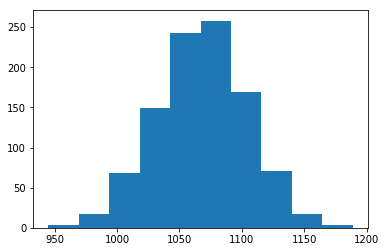

In [0]:
def system():
  arrival_times=arrival_ordered()
  Lemon=consumertype( arrival_times)
  service1=servicetime1( Lemon)
  service2=servicetime2( Lemon)
  rejected=system_sub(arrival_times, service1,service2,Lemon)
  return rejected
returns=[system() for i in range(1000)]
print("Variance:", np.std(returns,ddof=1)/1000**0.5)
plt.hist(returns)

##Achieve variance reduction through Control variate technique

Variance: 0.36365275405697217


(array([  3.,  16.,  60., 134., 191., 239., 162., 111.,  70.,  14.]),
 array([1032.37187356, 1039.06884742, 1045.76582129, 1052.46279515,
        1059.15976901, 1065.85674288, 1072.55371674, 1079.25069061,
        1085.94766447, 1092.64463833, 1099.3416122 ]),
 <a list of 10 Patch objects>)

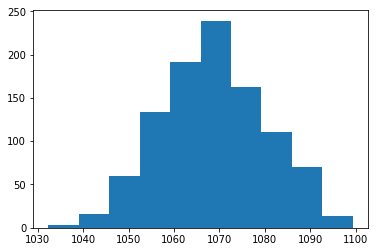

In [0]:
def system2():
  arrival_times=arrival_ordered()
  Lemon=consumertype( arrival_times)
  service1=servicetime1( Lemon)
  service2=servicetime2( Lemon)
  rejected_sample=system_sub(arrival_times, service1,service2,Lemon)
  return rejected_sample, len(arrival_times)

returns=[system2() for i in range(1000)]

outputs=np.array([item[0] for item in returns])
control=np.array([item[1] for item in returns])
c=-np.cov(outputs,control,ddof=1)[0,1]/np.var(control,ddof=1)
y=outputs+c*(control-LambdaT)

print("Variance:", np.std(y,ddof=1)/1000**0.5)
plt.hist(y)